The label of this leaf is Potato___healthy


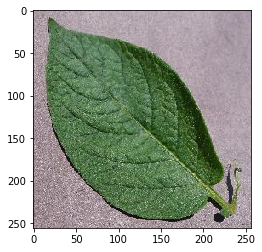

In [5]:
import os
import random 
import matplotlib.pyplot as plt

data_dir ='D:\\PlantVillage-Dataset\\raw\\color\\'
random_folder = random.choice(os.listdir(data_dir))
random_leaf = random.choice(os.listdir(data_dir+random_folder))
img=plt.imread(data_dir+random_folder + '/'+random_leaf)
plt.imshow(img)
print('The label of this leaf is',random_folder)


In [6]:
img.shape

(256, 256, 3)

The label of this leaf is  Orange___Haunglongbing_(Citrus_greening)


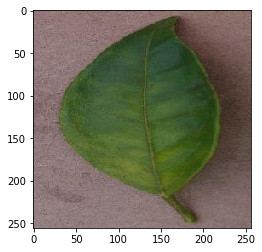

In [7]:
random_folder = random.choice(os.listdir(data_dir))
random_leaf = random.choice(os.listdir(data_dir+random_folder))
img2 = plt.imread(data_dir+ random_folder + '/'+random_leaf)
plt.imshow(img2)
print('The label of this leaf is ', random_folder)

In [8]:
img2.shape

(256, 256, 3)

In [9]:
negatives = 0
for f in os.listdir(data_dir):
    if (f.endswith("healthy") and not f.startswith(".")):
        imgs_list = os.listdir(data_dir+'/'+f)
        negatives += len(imgs_list)
print('Number of healthy cases = ', negatives)
positives = 54306-negatives
print('Number of diseased cases = ', positives)

Number of healthy cases =  15084
Number of diseased cases =  39222


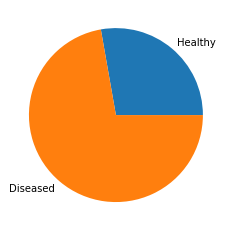

In [10]:
labels = 'Healthy','Diseased'
sizes = [negatives, positives]
plt.pie(sizes,labels=labels)
plt.show()

In [11]:
classes = {}
for f in os.listdir(data_dir):
    num = 0
    if (not f.startswith(".")):
        imgs_list = os.listdir(data_dir+'/'+f)
        num += len(imgs_list)
        classes[f] = num

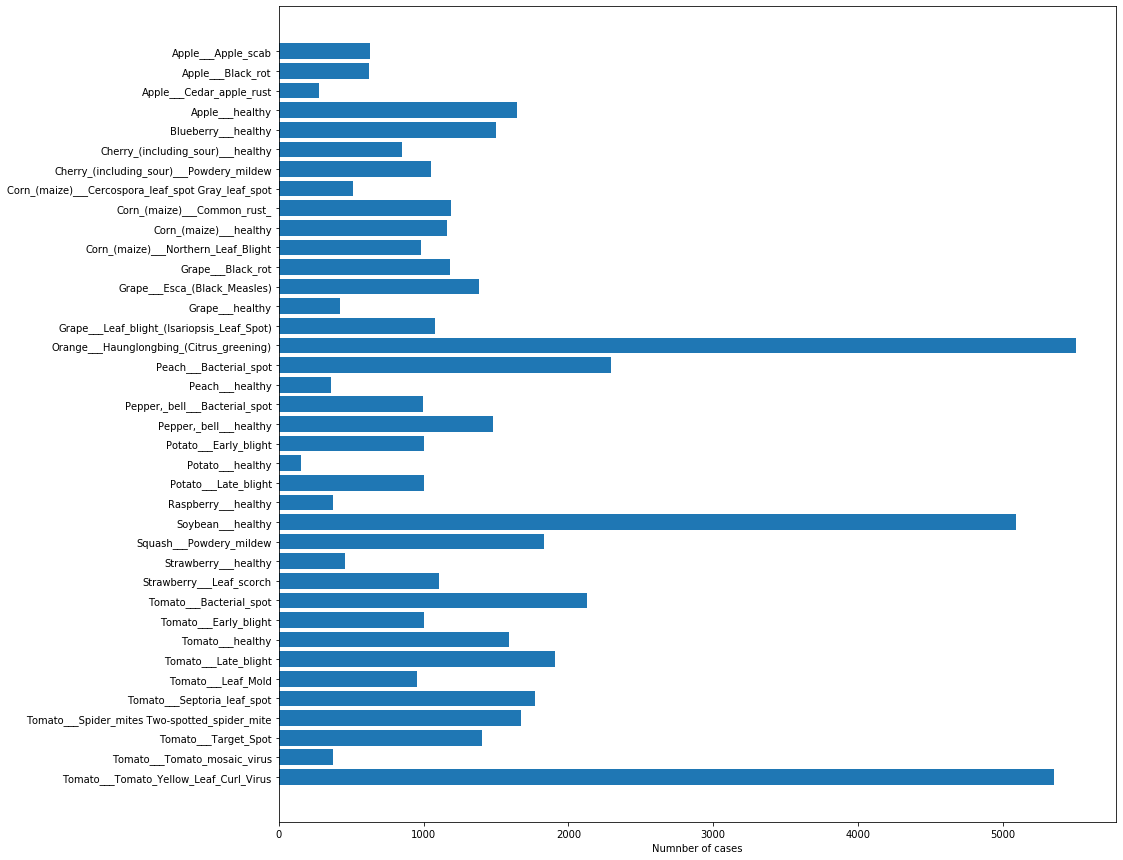

In [12]:
import numpy as np

fig, ax = plt.subplots(figsize=(15,15))
y_pos = np.arange(len(classes.keys()))
ax.barh(y_pos, classes.values())
ax.set_yticks(y_pos)
ax.set_yticklabels(classes.keys())
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Numnber of cases')

plt.show()

In [13]:

import pandas as pd

capstone_dir = os.getcwd()+'/'

data_list = []
for label in os.listdir(data_dir):
    if (not label.startswith(".")):
        imgs_list = os.listdir(data_dir + '/' + label)
        imgs_list = [i for i in imgs_list if not i.startswith(".")]
        label_list = [label]*len(imgs_list)
        if label.find('healthy')>=0:
            binary_list = ['0']*len(imgs_list)
        else:
            binary_list = ['1']*len(imgs_list)
        data_list.extend(zip(imgs_list, label_list, binary_list))
df = pd.DataFrame(data_list, columns=['Name','Label', 'Binary'])

In [14]:
df.shape

(54305, 3)

In [15]:
df.head(3)

,Name,Label,Binary
0,00075aa8-d81a-4184-8541-b692b78d398a___FREC_Sc...,Apple___Apple_scab,1
1,01a66316-0e98-4d3b-a56f-d78752cd043f___FREC_Sc...,Apple___Apple_scab,1
2,01f3deaa-6143-4b6c-9c22-620a46d8be04___FREC_Sc...,Apple___Apple_scab,1


In [16]:
df0 = df[df['Binary']=='0'].sample(n=1500, random_state=99)
df1 = df[df['Binary']=='1'].sample(n=1500, random_state=42)
df_svm = pd.concat([df0,df1])

In [18]:
df_svm.shape

(3000, 3)

In [19]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from skimage.color import rgb2grey
from skimage.feature import hog

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report

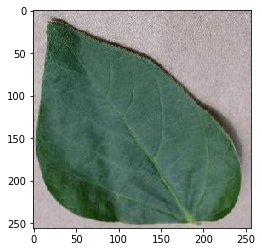

In [20]:
def get_image(img_inf, data_dir = data_dir):
    
    img_folder_name = img_inf['Label']
    img_file_name = img_inf['Name']
    img = Image.open(data_dir + img_folder_name + '/' + img_file_name)
    return np.array(img)

img_row = random.choice(range(3000))
img = get_image(df_svm.iloc[img_row])
plt.imshow(img)

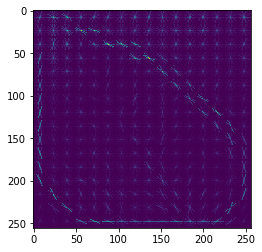

In [21]:
grey_img = rgb2grey(img)
hog_features, hog_image = hog(grey_img, visualize=True, block_norm='L2-Hys', pixels_per_cell=(16, 16))
plt.imshow(hog_image)

In [23]:
def create_feature_matrix(imgs_df):
    features_list = []
    for img_row in range(len(imgs_df)):
        img = get_image(imgs_df.iloc[img_row])
        grey_img = rgb2grey(img)
        hog_features = hog(grey_img, block_norm='L2-Hys', pixels_per_cell=(16, 16))
        features_list.append(hog_features)
    feature_matrix = np.array(features_list)
    return feature_matrix

feature_matrix = create_feature_matrix(df_svm)

In [24]:
feature_matrix.shape

(3000, 15876)

In [25]:
X = pd.DataFrame(feature_matrix)
y = pd.Series(df_svm['Binary'].values)
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=.4,
                                                    random_state=42)

In [26]:
print(pd.Series(y_train).value_counts())

1    918
0    882
dtype: int64


In [27]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [28]:
pca = PCA(.95)
pca.fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)
print('Number of components after fitting the pca model=', pca.n_components_)

Number of components after fitting the pca model= 971


In [29]:
clf = SVC(kernel='linear', probability=True, random_state=42)
clf.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

In [30]:
y_pred = clf.predict(X_test)

In [31]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.66      0.71      0.69       618
           1       0.67      0.62      0.64       582

    accuracy                           0.66      1200
   macro avg       0.66      0.66      0.66      1200
weighted avg       0.66      0.66      0.66      1200



In [32]:
def create_feature_vector_4pred(img_inf, data_dir=data_dir):
    
    img = get_image(img_inf)
    grey_img = rgb2grey(img)
    hog_features = hog(grey_img, block_norm='L2-Hys', pixels_per_cell=(16, 16))
    feature_vector = scaler.transform([hog_features])
    feature_vector = pca.transform(feature_vector)
    return feature_vector

In [33]:
one_img = pd.DataFrame([['04ce7b2d-5e41-43c6-9e11-e1bc4f5e4cca___RS_LB 3224.JPG',
                         'Potato___Late_blight', 
                         '1']], columns=['Name','Label', 'Binary'])

X_img = create_feature_vector_4pred(one_img.iloc[0])

y_img_pred = clf.predict(X_img)

if y_img_pred==1:
    print('The classifier detected the leaf as diseased.')
else:
    print('The classifier detected the leaf as healthy.')

The classifier detected the leaf as healthy.


In [34]:
one_img

,Name,Label,Binary
0,04ce7b2d-5e41-43c6-9e11-e1bc4f5e4cca___RS_LB 3...,Potato___Late_blight,1


In [35]:
if one_img.iloc[0]['Binary']==str(y_img_pred):
    print('Correct! Good job!')
else:
    print('Wrong! Bonehead!')

Wrong! Bonehead!
